In [1]:
import pvdeg
from pvdeg import TEST_DATA_DIR
import pickle
import xarray as xr
import pandas as pd
import numpy as np
import os

# Geospatial Templates

When running a geospatial analysis using `pvdeg.geospatial.analysis` on arbitary `pvdeg` functions you will need to specify a template for the shape of the output data. This is because the input data comes with dimensions of gid and time while the output will have data in a different shape usually corresonding to coordinates.
- gid, identification number corresponding to an NSRDB datapoint's location 
- time, timeseries corresponding to the hourly time indicies of NSRDB datapoint's yearly meteorological data.

Follow the steps below to see how we generate templates before running the analysis.

The only functions where this is not required are currently `pvdeg.standards.standoff`, `pvdeg.humidity.moduke` and, `letid.calc_letid_outdoors` as they are predefined within the package.

## Loading Geospatial Data

This step skips over making the `pvdeg.weather.get` call with `geospatial == True`. See the [Duramat Demo](./DuraMAT%20Live%20Demo.ipynb) for information on how to do this traditionally.

We can also use a `GeospatialScenario` object. See the [Geospatial Scenario Tutorial](./Scenario%20-%20Geospatial.ipynb) for more information on how to use this approach.

*The cell below loads a pickled xarray object, this is not the best way to do this. xarray datasets should be stored as `.nc` - netcdf files*

In [2]:
geo_meta = pd.read_csv(os.path.join(TEST_DATA_DIR, 'summit-meta.csv'), index_col=0)

with open(os.path.join(TEST_DATA_DIR, 'summit-weather.pkl'), 'rb') as f:
    geo_weather = pickle.load(f)

geo_weather

<xarray.Dataset> Size: 9MB
Dimensions:            (time: 17520, gid: 11)
Coordinates:
  * gid                (gid) int64 88B 449211 452064 453020 ... 460613 462498
  * time               (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T...
Data variables:
    temp_air           (time, gid) float64 2MB -12.0 -8.1 -14.2 ... -4.3 -6.2
    wind_speed         (time, gid) float64 2MB 0.6 0.6 0.3 0.6 ... 0.9 1.0 1.1
    dhi                (time, gid) float64 2MB 0.0 0.0 0.0 ... 13.0 18.0 19.0
    ghi                (time, gid) float64 2MB 0.0 0.0 0.0 ... 13.0 24.0 19.0
    dni                (time, gid) float64 2MB 0.0 0.0 0.0 0.0 ... 0.0 126.0 1.0
    relative_humidity  (time, gid) float64 2MB 99.93 79.41 100.0 ... 95.93 100.0
Attributes:
    full_version_record:  {"rex": "0.2.80", "pandas": "2.0.0", "numpy": "1.23...
    package:              rex
    version:              4.0.0

# Creating Templates Manually

`pvdeg.geospatial.ouput_template` we can produce a template for our result data. 

We need to do this because different functions return different types of values, some return multiple values as tuples, some return only single numerics, others return timeseries results. We need to specify the shape of our data to create an output xarray dataset. 

## Examples

## 98ᵗʰ module percential temperature at Standoff Height

Say we want to estimate the 98ᵗʰ percential temperature for the module at the given tilt, azimuth, and x_eff. `PVDeg` has a function to do this, `pvdeg.standards.T98_estimate` BUT it doesn't have a preset geospatial template. We will need to make one.

- look at the function return values. 
From the docstring we can see that `T98_estimate` only has one return value. IMPORTANT, this value is a single float, NOT a timeseries. This means our output shape will only be dependent on the input identifier and NOT time. 

Therefore we will map the output variable `T98` to the location identifier `gid` using a dictionary with `str: tuple` mappings.

 *IMPORTANT: you must use the syntax below where the variable maps to a tuple of the coordinates. in this case there needs to be a trailing comma in the tuple or python will iterate over the characters in the tuple instead of the elements. See further examples to alleviate confusion.*

In [3]:
# define output shape
shapes = {
    "T98" : ("gid",) # one return value at each datapoint, only dependent on datapoint, not time
}

# create xarray template for output to be populated when analysis is run
template = pvdeg.geospatial.output_template(
    ds_gids=geo_weather, 
    shapes=shapes,
)

In [4]:
geo_estimate_temp = pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.standards.T98_estimate,
    template=template
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

## Glass Glass Estimated Module Temperature

Now we want to calculate geospatial timeseries temperature values for a module using `pvdeg.temperature.module`. This is not super practical because all `pvdeg` functions that need to use tempeature for their calculations preform the temperature calculation internally, this is just for show. 

This calculation differs from the above because the temperature functions return the module temperature in a timeseries format. So we care about 2 dimensions, location identifier and TIME.

In [5]:
# define output shape
shapes = {
    "module_temperature" : ("gid", "time") # one return value at each datapoint, only dependent on datapoint, not time 
}

# create xarray template for output to be populated when analysis is run
temperature_template = pvdeg.geospatial.output_template(
    ds_gids=geo_weather, 
    shapes=shapes,
)

In [6]:
geo_temperature_res = pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.temperature.module,
    template=temperature_template, # use the template we created

    conf='open_rack_glass_glass' # provide kwargs for function here
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

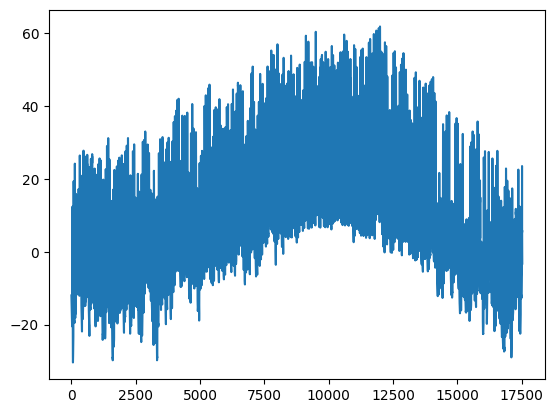

In [7]:
# plot the temperature at ONE of the geospatial analysis result locations but we have calculated all of these.
import matplotlib.pyplot as plt
module_temps = geo_temperature_res['module'].sel(latitude=39.89, longitude='-106.42').values

plt.plot(module_temps)

## Self Explaining Code

If we are looking at adding templates for other functions, we can also look at the 3 presaved templates for existing `pvdeg` functions. Visit [pvdeg.geospatial.template_parameters](../../pvdeg/geospatial.py) and inspect this function to see how these different target functions utilize templates and shapes.

# Creating Templates Programatically

We can use `pvdeg.geospatial.autotemplate` to generate a template for a given function. This can return a bad result which will fail or work improperly when running `pvdeg.geospatial.analysis` with the generated template. Results should be scrutinized to make sure they are the right format.

## Examples Below
Steps
- Create template using autotemplating function. Pulls in information about function to determine shape of output. Not usable on functions with ambigious return types.
- Call geospatial analysis function using template

### Geospatial Cell Temperature Calculation

In [8]:
# create a template using auto_template for the desired function
cell_temp_template = pvdeg.geospatial.auto_template(
    func=pvdeg.temperature.cell,
    ds_gids=geo_weather
)

# run the geospatial analysis with the template
pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.temperature.cell,
    template=cell_temp_template
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

<xarray.Dataset> Size: 11MB
Dimensions:    (latitude: 8, longitude: 10, time: 17520)
Coordinates:
  * latitude   (latitude) float64 64B 39.41 39.45 39.53 ... 39.69 39.81 39.89
  * longitude  (longitude) float64 80B -106.4 -106.3 -106.3 ... -105.9 -105.9
  * time       (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T23:30:00
Data variables:
    cell       (time, latitude, longitude) float64 11MB nan nan nan ... nan nan

### Geospatial Module Temperature Calculation

In [9]:
module_temp_template = pvdeg.geospatial.auto_template(
    func=pvdeg.temperature.module,
    ds_gids=geo_weather
)

pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.temperature.module,
    template=module_temp_template
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

<xarray.Dataset> Size: 11MB
Dimensions:    (latitude: 8, longitude: 10, time: 17520)
Coordinates:
  * latitude   (latitude) float64 64B 39.41 39.45 39.53 ... 39.69 39.81 39.89
  * longitude  (longitude) float64 80B -106.4 -106.3 -106.3 ... -105.9 -105.9
  * time       (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31T23:30:00
Data variables:
    module     (time, latitude, longitude) float64 11MB nan nan nan ... nan nan

### Geospatial Solar Position Calculation

In [10]:
solar_position_template = pvdeg.geospatial.auto_template(
    func=pvdeg.spectral.solar_position,
    ds_gids=geo_weather
)

pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.spectral.solar_position,
    template=solar_position_template
)

<xarray.Dataset> Size: 67MB
Dimensions:             (latitude: 8, longitude: 10, time: 17520)
Coordinates:
  * latitude            (latitude) float64 64B 39.41 39.45 39.53 ... 39.81 39.89
  * longitude           (longitude) float64 80B -106.4 -106.3 ... -105.9 -105.9
  * time                (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31...
Data variables:
    apparent_zenith     (time, latitude, longitude) float64 11MB nan nan ... nan
    zenith              (time, latitude, longitude) float64 11MB nan nan ... nan
    apparent_elevation  (time, latitude, longitude) float64 11MB nan nan ... nan
    elevation           (time, latitude, longitude) float64 11MB nan nan ... nan
    azimuth             (time, latitude, longitude) float64 11MB nan nan ... nan
    equation_of_time    (time, latitude, longitude) float64 11MB nan nan ... nan

### Geospatial POA Irradiance Calculation

In [11]:
poa_irradiance_template = pvdeg.geospatial.auto_template(
    func=pvdeg.spectral.poa_irradiance,
    ds_gids=geo_weather
)

pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.spectral.poa_irradiance,
    template=poa_irradiance_template
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

<xarray.Dataset> Size: 56MB
Dimensions:             (latitude: 8, longitude: 10, time: 17520)
Coordinates:
  * latitude            (latitude) float64 64B 39.41 39.45 39.53 ... 39.81 39.89
  * longitude           (longitude) float64 80B -106.4 -106.3 ... -105.9 -105.9
  * time                (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31...
Data variables:
    poa_global          (time, latitude, longitude) float64 11MB nan nan ... nan
    poa_direct          (time, latitude, longitude) float64 11MB nan nan ... nan
    poa_diffuse         (time, latitude, longitude) float64 11MB nan nan ... nan
    poa_sky_diffuse     (time, latitude, longitude) float64 11MB nan nan ... nan
    poa_ground_diffuse  (time, latitude, longitude) float64 11MB nan nan ... nan

### Geospatial 98th Percentile Operating Temperature Calculation

In [12]:
standoff_template = pvdeg.geospatial.auto_template(
    func=pvdeg.standards.T98_estimate, 
    ds_gids=geo_weather
    )

pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.standards.T98_estimate,
    template=standoff_template
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

<xarray.Dataset> Size: 784B
Dimensions:       (latitude: 8, longitude: 10)
Coordinates:
  * latitude      (latitude) float64 64B 39.41 39.45 39.53 ... 39.69 39.81 39.89
  * longitude     (longitude) float64 80B -106.4 -106.3 -106.3 ... -105.9 -105.9
Data variables:
    T98_estimate  (latitude, longitude) float64 640B nan nan nan ... nan nan nan

### Geospatial Module Humidity Calculation

In [13]:
humidity_template = pvdeg.geospatial.auto_template(
    func=pvdeg.humidity.module,
    ds_gids=geo_weather
)

pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.humidity.module,
    template=humidity_template
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.5 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.6 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.5 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.6 was used.


<xarray.Dataset> Size: 45MB
Dimensions:             (latitude: 8, longitude: 10, time: 17520)
Coordinates:
  * latitude            (latitude) float64 64B 39.41 39.45 39.53 ... 39.81 39.89
  * longitude           (longitude) float64 80B -106.4 -106.3 ... -105.9 -105.9
  * time                (time) datetime64[ns] 140kB 2022-01-01 ... 2022-12-31...
Data variables:
    RH_surface_outside  (time, latitude, longitude) float64 11MB nan nan ... nan
    RH_front_encap      (time, latitude, longitude) float64 11MB nan nan ... nan
    RH_back_encap       (time, latitude, longitude) float64 11MB nan nan ... nan
    RH_backsheet        (time, latitude, longitude) float64 11MB nan nan ... nan

### Geospatial IwaVantHoff Environment Characterization Calculation

In [14]:
iwa_vant_hoff_template = pvdeg.geospatial.auto_template(
    func=pvdeg.degradation.IwaVantHoff,
    ds_gids=geo_weather
)

pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.degradation.IwaVantHoff,
    template=iwa_vant_hoff_template
)

The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.9 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.7 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.8 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provided, therefore the latitude tilt of 39.4 was used.
The array azimuth was not provided, therefore an azimuth of 180.0 was used.
The array tilt angle was not provi

<xarray.Dataset> Size: 784B
Dimensions:      (latitude: 8, longitude: 10)
Coordinates:
  * latitude     (latitude) float64 64B 39.41 39.45 39.53 ... 39.69 39.81 39.89
  * longitude    (longitude) float64 80B -106.4 -106.3 -106.3 ... -105.9 -105.9
Data variables:
    IwaVantHoff  (latitude, longitude) float64 640B nan nan nan ... nan nan nan

### Geospatial Edge Seal Width Calculation

In [15]:
edge_seal_template = pvdeg.geospatial.auto_template(
    func=pvdeg.design.edge_seal_width,
    ds_gids=geo_weather
)

pvdeg.geospatial.analysis(
    weather_ds=geo_weather,
    meta_df=geo_meta,
    func=pvdeg.design.edge_seal_width,
    template=edge_seal_template
)

<xarray.Dataset> Size: 784B
Dimensions:          (latitude: 8, longitude: 10)
Coordinates:
  * latitude         (latitude) float64 64B 39.41 39.45 39.53 ... 39.81 39.89
  * longitude        (longitude) float64 80B -106.4 -106.3 ... -105.9 -105.9
Data variables:
    edge_seal_width  (latitude, longitude) float64 640B nan nan nan ... nan nan

In [16]:
edge_seal_template

<xarray.Dataset> Size: 176B
Dimensions:  (gid: 11)
Coordinates:
  * gid      (gid) int64 88B 449211 452064 453020 ... 459670 460613 462498
Data variables:
    width    (gid) float64 88B dask.array<chunksize=(11,), meta=np.ndarray>